# Yield Model Calculator for D2W hybrid bonding
#### Author: Zhichao Chen
#### Date: Oct 3, 2024
#### Description: V2 (overlay errors, particulate defects, Cu expansion, surface roughness)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from assembly_yield_calculator import Assembly_Yield_Calculator

In [3]:
# DIE PARAMETERS
NUM_DIES_ON_WAF = 160
# PER WAFER PARAMETERS
PITCH = 6  # pitch (um)
DIE_W = 1e+4  # die width (um)
DIE_L = 1e+4  # die length (um)
WAF_R = 150e+3  # wafer radius (um)
PAD_TOP_R = 1.0  # top Cu pad radius (um)
PAD_BOT_R = 1.5  # bottom Cu pad radius (um)
PAD_ARR_ROW = int(np.floor(float(DIE_L / PITCH)))  # number of pads in a row of pad array
PAD_ARR_COL = int(np.floor(float(DIE_W / PITCH)))  # number of pads in a column of pad array
VOID_SHAPE = "circle"  # void shape: 'circle' or 'square'
dice_width = 1e+4 # dice width (um)

# Overlay Model Parameters
RANDOM_MISALIGNMENT_MEAN = 5e-3
RANDOM_MISALIGNMENT_STD = 1e-2
# Assume the systematic translation is normally distributed
SYSTEM_TRANSLATION_X_MEAN = 5e-3  # systematic translation mean (um) - x direction
SYSTEM_TRANSLATION_X_STD = 1e-2  # systematic translation standard deviation (um)  - x direction
SYSTEM_TRANSLATION_Y_MEAN = 1e-2  # systematic translation mean (um) - y direction
SYSTEM_TRANSLATION_Y_STD = 1e-2  # systematic translation standard deviation (um)  - y direction
# Assume the systematic rotation is normally distributed
SYSTEM_ROTATION_MEAN = 1e-7  # systematic rotation mean (rad)
SYSTEM_ROTATION_STD = 0.5e-7  # systematic rotation standard deviation (rad)
# Assume the bow difference is normally distributed
BOW_DIFFERENCE_MEAN = 10  # bow difference mean (um)
BOW_DIFFERENCE_STD = 3  # bow difference standard deviation (um)
# systematic magnification model: e = k_mag * bow_diff
k_mag = 0.09
M_0 = 0
SYSTEM_MAGNIFICATION_MEAN = (k_mag * BOW_DIFFERENCE_MEAN + M_0) / 1e6  # systematic magnification mean (ppm)
SYSTEM_MAGNIFICATION_STD = (k_mag * BOW_DIFFERENCE_STD) ** 2 / 1e6 # systematic magnification standard deviation (ppm)

# Defect Model Parameters
D0 = 1e-9  # Number of particles of all thicknesses per unit area (um^{-1})
z = 3  # Exponential factor of the particle thickness distribution
t_0 = 0.1  # The smallest particle thickness (um)
L_m = WAF_R  # Beyond this distance, no voids in the void tail
k_r = 1.8e-4
k_r0 = 230
k_L = 6.2e-2
k_n = 9e-5
k_S = 2.7
cluster_para = 0.1

# Cu expansion model parameters
# Cu pad dish mean and standard deviation at room temperature
TOP_DISH_MEAN = -10.0        # Top Cu pad dish mean (nm), negative value means the dish is concave
TOP_DISH_STD = 1.0          # Top Cu pad dish standard deviation (nm)
BOT_DISH_MEAN = -10.0        # Bottom Cu pad dish mean (nm), negative value means the dish is concave
BOT_DISH_STD = 1.0          # Bottom Cu pad dish standard deviation (nm)
# Expansion coefficient of Cu pad,      ΔH = k_e * ΔT
k_et = 0.052            # Top Cu pad expansion/temp coefficient (nm/K)
k_eb = 0.052            # Bottom Cu pad expansion/temp coefficient (nm/K)
T_R = 25                # Room temperature (°C)
T_anl = 300             # Annealing temperature (°C)

# Roughness model parameters
Asperity_R = 2e-6  # Asperity curvature radius (m)
Roughness_sigma = 1.0e-9  # Surface roughness standard deviation (m)
eta_s = 40e+12  # Asperity density (m^{-2})
Roughness_constant = 0.07
Adhesion_energy = 1.2  # Adhesion energy (J/m^2)
Young_modulus = 73e+9  # Young's modulus of dielectric material (Pa)
Dielectric_thickness = 1.5e-6  # Dielectric thickness (m)
DISH_0 = 75e-9  # Reference dish (m)
k_peel = 6.66e+15  # Peel force constant (N/m^4/K)

In [6]:
# PER WAFER PARAMETERS
PITCH = 10  # pitch (um)
DIE_W = 1e4 # die width (um)
DIE_L = 1e4 # die length (um)
WAF_R = 150e+3  # wafer radius (um)
PAD_BOT_R = PITCH / 2 / 2 # bottom Cu pad radius (um)
PAD_TOP_R = PAD_BOT_R / 1.5  # top Cu pad radius (um)
PAD_ARR_ROW = int(np.floor(float(DIE_L / PITCH)))  # number of pads in a row of pad array
PAD_ARR_COL = int(np.floor(float(DIE_W / PITCH)))  # number of pads in a column of pad array
# explore the impact of particle density on the assembly yield

num_points = 10

die_size_list = np.linspace(8e+4, 8e+4, num_points)
pitch_list = np.linspace(10, 10, num_points)
particle_density_list = np.logspace(-10, -8, num_points)
t_0_list = np.linspace(0.1, 0.1, num_points)
dish_std_list = np.linspace(1, 1, num_points)
translation_list = np.linspace(1e-2, 1e-2, num_points)
rotation_mean_list = np.logspace(-7, -7, num_points)
Roughness_sigma_list = np.linspace(1.0e-9, 1.0e-9, num_points)
PAD_BOT_R_ratio_list = np.linspace(0.5, 0.5, num_points)
PAD_TOP_R_ratio_list = np.linspace(2/3, 2/3, num_points)
bow_difference_mean_list = np.linspace(10, 10, num_points)
assembly_yield_list = []
overlay_yield_list = []
defect_yield_list = []
Cu_expansion_yield_list = []
for i in range(num_points):
    DIE_W = die_size_list[i]  # die width (um)
    DIE_L = die_size_list[i]  # die length (um)
    PAD_ARR_ROW = int(np.floor(float(DIE_L / pitch_list[i])))  # number of pads in a row of pad array
    PAD_ARR_COL = int(np.floor(float(DIE_W / pitch_list[i])))  # number of pads in a column of pad array
    PAD_BOT_R = pitch_list[i] / 2 * PAD_BOT_R_ratio_list[i]  # bottom Cu pad radius (um)
    PAD_TOP_R = PAD_BOT_R * PAD_TOP_R_ratio_list[i]  # top Cu pad radius (um)
    assembly_yield, overlay_yield, defect_yield, Cu_expansion_yield = Assembly_Yield_Calculator(
        NUM_DIES_ON_WAF=NUM_DIES_ON_WAF,
        WAF_R=WAF_R,
        PITCH=pitch_list[i],
        DIE_W=die_size_list[i],
        DIE_L=die_size_list[i],
        PAD_TOP_R=PAD_TOP_R,
        PAD_BOT_R=PAD_BOT_R,
        PAD_ARR_ROW=PAD_ARR_ROW,
        PAD_ARR_COL=PAD_ARR_COL,
        VOID_SHAPE='square',
        dice_width=0,
        SYSTEM_TRANSLATION_X_MEAN=translation_list[i],
        SYSTEM_TRANSLATION_X_STD=SYSTEM_TRANSLATION_X_STD,
        SYSTEM_TRANSLATION_Y_MEAN=translation_list[i],
        SYSTEM_TRANSLATION_Y_STD=SYSTEM_TRANSLATION_Y_STD,
        SYSTEM_ROTATION_MEAN=rotation_mean_list[i],
        SYSTEM_ROTATION_STD=SYSTEM_ROTATION_STD,
        BOW_DIFFERENCE_MEAN=bow_difference_mean_list[i],
        BOW_DIFFERENCE_STD=BOW_DIFFERENCE_STD,
        k_mag=k_mag,
        M_0=M_0,
        D0=particle_density_list[i],
        z=z,
        t_0=t_0_list[i],
        k_r=k_r,
        k_r0=k_r0,
        k_L=k_L,
        k_n=k_n,
        k_S=k_S,
        TOP_DISH_MEAN=TOP_DISH_MEAN,
        TOP_DISH_STD=dish_std_list[i],
        BOT_DISH_MEAN=BOT_DISH_MEAN,
        BOT_DISH_STD=dish_std_list[i],
        k_et=k_et,
        k_eb=k_eb,
        T_R=T_R,
        T_anl=T_anl,
        Asperity_R=Asperity_R,
        Roughness_sigma=Roughness_sigma_list[i],
        eta_s=eta_s,
        Roughness_constant=Roughness_constant,
        Adhesion_energy=Adhesion_energy,
        Young_modulus=Young_modulus,
        Dielectric_thickness=Dielectric_thickness,
        DISH_0=DISH_0,
        k_peel=k_peel
    )
    assembly_yield_list.append(assembly_yield)
    overlay_yield_list.append(overlay_yield)
    defect_yield_list.append(defect_yield)
    Cu_expansion_yield_list.append(Cu_expansion_yield)
print("overlay_yield_list: ", overlay_yield_list)
print("defect_yield_list: ", defect_yield_list)
print("Cu_expansion_yield_list: ", Cu_expansion_yield_list)
print("assembly_yield_list: ", assembly_yield_list)

overlay_yield_list:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
defect_yield_list:  [0.5256741035135915, 0.3420796047175593, 0.16706185582692942, 0.05054535011940868, 0.0068803404549137165, 0.0002471245891738672, 9.616591666761597e-07, 9.184899123982858e-11, 1.8088351950277532e-17, 1.1793922703776772e-28]
Cu_expansion_yield_list:  [0.9625290010548677, 0.9625290010548677, 0.9625290010548677, 0.9625290010548677, 0.9625290010548677, 0.9625290010548677, 0.9625290010548677, 0.9625290010548677, 0.9625290010548677, 0.9625290010548677]
assembly_yield_list:  [0.5059765697353503, 0.3292615402100364, 0.1608018812034667, 0.048651365358402976, 0.006622527224985493, 0.00023786458395361695, 9.256248370560605e-07, 8.84073177859695e-11, 1.74105633334295e-17, 1.135199263858458e-28]


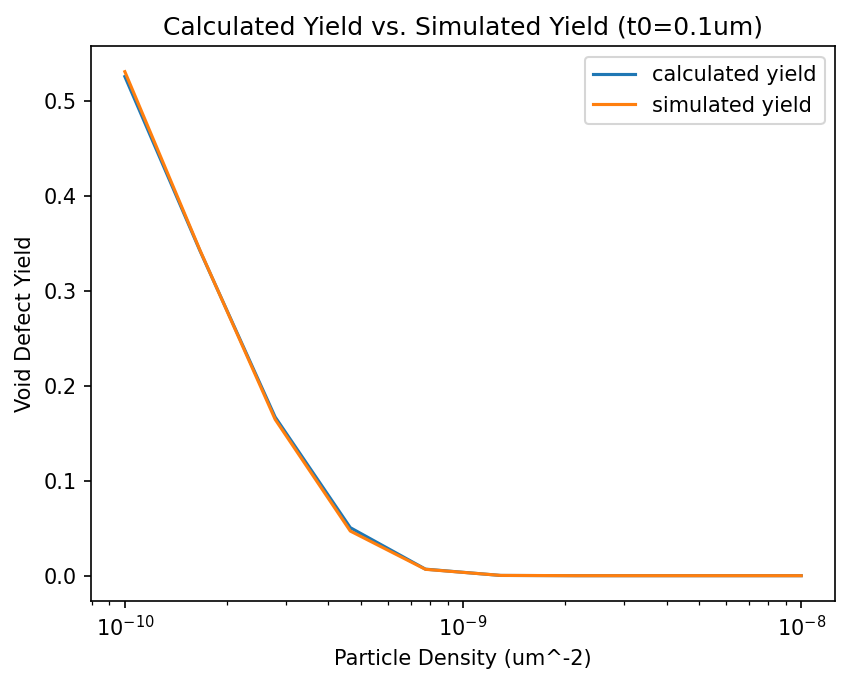

[[1.         0.99995626]
 [0.99995626 1.        ]]


In [7]:
particle_density_list = np.logspace(-10, -8, 10)
calculate_particle_yield = [0.5256741035135915, 0.3420796047175593, 0.16706185582692942, 0.05054535011940868, 0.0068803404549137165, 0.0002471245891738672, 9.616591666761597e-07, 9.184899123982858e-11, 1.8088351950277532e-17, 1.1793922703776772e-28]
simulate_particle_yield = [0.5308, 0.3427, 0.1646, 0.047, 0.0067, 0.0003, 0.0, 0.0, 0.0, 0.0]
calculate_particle_yield = np.array(calculate_particle_yield)
simulate_particle_yield = np.array(simulate_particle_yield)

# plot the calculated yield vs. the simulated yield
plt.figure(dpi=150)
plt.plot(particle_density_list, calculate_particle_yield, label='calculated yield')
plt.plot(particle_density_list, simulate_particle_yield, label='simulated yield')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Void Defect Yield')
plt.title('Calculated Yield vs. Simulated Yield (t0=0.1um)')
plt.legend()
plt.show()

# Calculate the correlation between the calculated yield and the simulated yield
print(np.corrcoef(calculate_particle_yield, simulate_particle_yield))
